<a href="https://colab.research.google.com/github/AITrading1995/AITrading1995/blob/main/Monte_Carlo_OI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mplfinance
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git

In [19]:
from tvDatafeed import TvDatafeed, Interval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import importlib
importlib.reload(plt)
from scipy.stats import skew , kurtosis, shapiro

In [4]:
def downloads (symbol,bar):
  tv = TvDatafeed()
  df = tv.get_hist(symbol=symbol, exchange='COMEX', interval=Interval.in_daily,n_bars=bar)
  if 'symbol' in df:
    df.drop(columns='symbol', inplace=True)
  return df

In [5]:
symbol='GC1!'
bar = 252
df=downloads(symbol,bar)

In [6]:
def calculator(data):
    if 'close' not in data:
        print('Data Not Available')
        return None
    else:
        # ลบคอลัมน์ 'open', 'high', 'low', 'volume' ออกจาก data
        data.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

        # คำนวณผลตอบแทน (return) โดยใช้ pct_change
        data['return'] = data['close'].pct_change() * 100

        # คำนวณค่าเบี่ยงเบนมาตรฐาน (sigma) ของผลตอบแทน
        data['sigma'] = np.std(data['return'].dropna())

        # คำนวณความแปรปรวน (variance)
        data['variance'] = data['sigma'] ** 2
        data['annualize'] = data['sigma']*np.sqrt(252)
        data['var_annualize'] = data['annualize']**2

    return data

In [7]:
df = calculator(df)

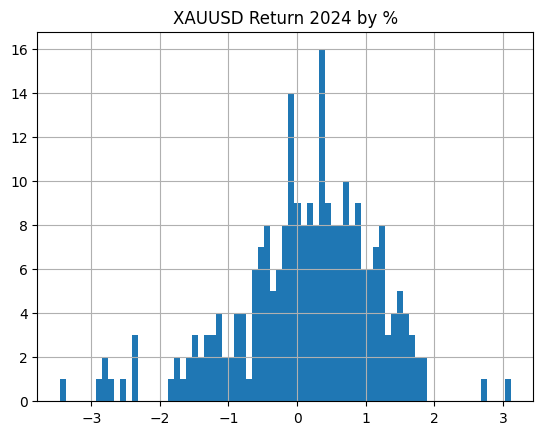

In [8]:
plt.hist(df['return'],bins=75, label='XAUUSD Return')
plt.title('XAUUSD Return 2024 by %')
plt.grid(True)
plt.show()

In [9]:
print(df['return'].tail())

datetime
2025-03-16 22:00:00    0.166606
2025-03-17 22:00:00    1.154320
2025-03-18 22:00:00    0.013154
2025-03-19 22:00:00    0.085493
2025-03-20 22:00:00    0.233261
Name: return, dtype: float64


In [10]:
#Skew test
clean_data = df['return'].dropna()
return_skew = skew(clean_data)
#kurtosis
return_kurtosis = kurtosis(clean_data)
fourth_kurtosis = return_kurtosis +3
shapiro_test = shapiro(clean_data)

print('fourth_kurtosis',fourth_kurtosis)
print('Kurtosis', return_kurtosis)
print('Skew', return_skew)

print('Shapiro',shapiro_test[1])

fourth_kurtosis 4.008937009242128
Kurtosis 1.0089370092421284
Skew -0.6552260161327818
Shapiro 3.354790676743965e-05


In [22]:
def monte_carlo(df, time, days, target_price):
    if 'close' not in df.columns:
        print('Data Not Available')
        return None
    else:
        # คำนวณผลตอบแทนแบบ Log Return
        df['log_return'] = np.log(df['close'] / df['close'].shift(1))

        # คำนวณค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐานของผลตอบแทน
        mean_return = df['log_return'].mean()
        sd_return = df['log_return'].std()

        # สร้างอาร์เรย์สำหรับเก็บผลลัพธ์การจำลอง
        simulation = np.zeros((time, days))

        # ทำการจำลอง Monte Carlo
        for i in range(time):
            simulated_return = np.random.normal(mean_return, sd_return, days)
            simulated_price = df['close'].iloc[-1] * np.exp(np.cumsum(simulated_return))
            simulation[i] = simulated_price

        # คำนวณความน่าจะเป็นที่ราคาจะสูงกว่า target_price
        # เปรียบเทียบราคาที่จำลองกับ target_price
        final_prices = simulation[:, -1]  # ราคาสุดท้ายหลังจากการจำลอง
        probability_up = np.sum(final_prices > target_price) / time
        probability_dow = np.sum(final_prices < target_price)/time
        print(f"The probability of price  over {target_price} after {days} Day is: {probability_up * 100:.2f}%")
        print(f"The probability of price  under {target_price} after {days} Day is: {probability_dow * 100:.2f}%")
        # แสดงผลลัพธ์การจำลอง
        plt.figure(figsize=(12, 8))
        plt.plot(simulation.T, color='blue', alpha=0.1)
        plt.title('Monte Carlo Simulation for Price Movement')
        plt.xlabel('Day')
        plt.ylabel('Price (USD)')
        plt.show()

The probability of price  over 3100 after 35 Day is: 69.61%
The probability of price  under 3100 after 35 Day is: 30.39%


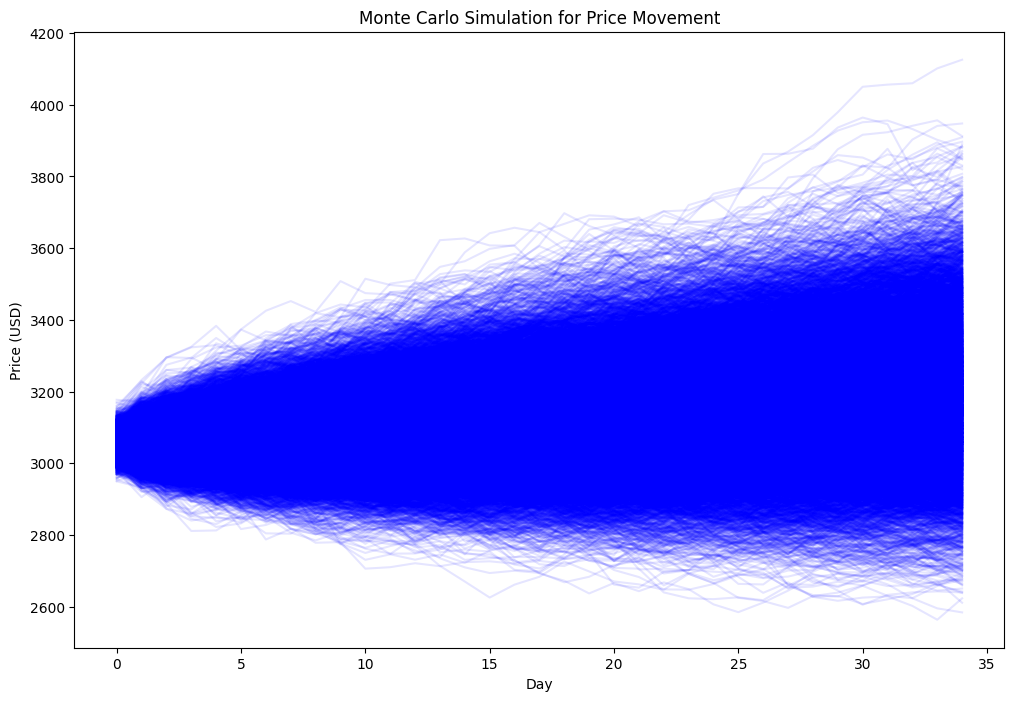

In [36]:
time = 100_00 # จำลอง จำนวนครั้ง
predict =35 #จำนวนวันที่หมดอายุ
target = 3100 # ระดับราคาที่สนใจ
test = monte_carlo(df,time, predict,target)